Compares cluster analyses done with different tracer combinations

In [1]:
from matplotlib.mlab import griddata
import matplotlib.pyplot as plt

from numpy import linspace
from numpy import meshgrid
from numpy.random import uniform, seed

from mpl_toolkits.basemap import Basemap, shiftgrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


title_sz = 27
axis_sz = 22
tick_sz = 21

from matplotlib.ticker import MaxNLocator
from matplotlib import cm, rcParams
rcParams.update({'font.size': tick_sz-4}) # Increase font-size
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.cm as cm
from matplotlib import gridspec

import pylab as pl

from itertools import islice
import sys, pickle, time, copy, re

from collections import Counter

from chem_ocean import Build_Map as bm
# from chem_ocean import Plot_Raw2 as pr

In [2]:
from sklearn import cluster, metrics
from sklearn.metrics import euclidean_distances, silhouette_samples, silhouette_score
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

import time

In [3]:
# load data from database for tracer combination
# produce model output

In [4]:
import sqlalchemy
import numpy as np
from collections import defaultdict

In [5]:
def connect(user, password, db, host='localhost', port=5432):
    '''Returns a connection and a metadata object'''
    url  = 'postgresql://{}:{}@{}:{}/{}'
    url = url.format(user, password, host, port, db)

    # The return value of create_engine() is our connection object
    con = sqlalchemy.create_engine(url, client_encoding='utf8')

    # We then bind the connection to MetaData()
    meta = sqlalchemy.MetaData(bind=con, reflect=True)

    return con, meta, url

In [6]:
def return_from_psql(query, cols, _in_var_names, _x_var, _y_var):
    conn, meta, url = connect('jlanders', '', 'odv_app_dev', host='localhost', port=5432)
    result = conn.execute(query)
    
    cluster_d = defaultdict(list)
    for row in result:
        for ik, col in enumerate(cols):
            cluster_d[col].append(row[ik])
    
    _x = np.asarray(cluster_d[_x_var])
    _y = np.asarray(cluster_d[_y_var])
    
    _feat_data = np.zeros((len(cluster_d['station']), len(_in_var_names))) 
    for ik, name in enumerate(_in_var_names):
        _feat_data[:, ik] = np.asarray(cluster_d[name])

    mask = np.all(np.isnan(_feat_data), axis=1)
    _x = _x[~mask]
    _y = _y[~mask]
    _feat_data = _feat_data[~mask]
    
    return cluster_d, _feat_data, _x, _y

In [7]:
def get_plan(lat_bounds, lon_bounds, _var_names, depth):
    sum_names = ['station', 'longitude', 'latitude', 'depth'] + _var_names
    cols = ', '.join(sum_names)
    query = "select "+ cols+ " from woa13 where latitude> {} AND latitude< {} AND longitude>{} and longitude<{} and depth={};".format(str(lat_bounds[0]), str(lat_bounds[1]), str(lon_bounds[0]), str(lon_bounds[1]), str(depth))
    
    _x_var = 'longitude'
    _y_var = 'latitude'

    cluster_d, _feat_data, _x, _y = return_from_psql(query, sum_names, _var_names, _x_var, _y_var)
    
    _basemap = True
    _latLon_params = None
    
    return _x, _y, _feat_data, _basemap, _x_var.title()+' (deg)', _y_var.title()+' (deg)', _latLon_params
    
def get_section(traj_type, line, limits, _var_names):
    sum_names = ['station', 'longitude', 'latitude', 'depth'] + _var_names
    cols = ', '.join(sum_names)
    traj_bounds = (line-1.5, line+1.5)
    
    if traj_type == 'EW_section':
        query = "select "+ cols+ " from woa13 where latitude> {} AND latitude< {} AND longitude>{} and longitude<{};".format(str(traj_bounds[0]), str(traj_bounds[1]), str(limits[0]), str(limits[1]))
        
        _x_var = 'longitude'
        _y_var = 'depth'
        
        cluster_d, _feat_data, _x, _y = return_from_psql(query, sum_names, _var_names, _x_var, _y_var)

        _yLab = 'Depth (m))'  
        _xLab = 'Longitude (deg) along '+ r'%s $^\circ$' % abs(line)+ ['S' if lat<0 else 'N' for lat in [line]][0]
        _basemap = False
        _latLon_params = (limits, (line, line))
        
    if traj_type == 'NS_section':
        query = "select "+ cols+ " from woa13 where latitude> {} AND latitude< {} AND longitude>{} and longitude<{};".format(str(limits[0]), str(limits[1]), str(traj_bounds[0]), str(traj_bounds[1]))
        
        _x_var = 'latitude'
        _y_var = 'depth'
        
        cluster_d, _feat_data, _x, _y = return_from_psql(query, sum_names, _var_names, _x_var, _y_var)
        
        _yLab = 'Depth (m)'  
        _xLab = 'Latitude (deg) along '+ r'%s $^\circ$' % abs(line)+ ['W' if lon<0 else 'E' for lon in [line]][0]
        _basemap = False
        _latLon_params = ((line, line), limits)

    return _x, _y, _feat_data, _basemap, _xLab, _yLab, _latLon_params


In [8]:
#takes a list of models rather than a single model
def test_clustering4(_x, _y, _data, _xLab, _yLab, N_CLUSTERS, _latLon_params, _basemp, models):
    pred_dict = {}
    np.random.seed(0)

    colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
    colors = np.hstack([colors] * 20)
    
    plot_num = 1
    X = _data
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    
    # Compute distances
    # create clustering estimators
    alg_list = []
    for model in models:
        
        # estimate bandwidth for mean shift
        bandwidth = cluster.estimate_bandwidth(X, quantile=0.3)
        ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
        
        if model in ['ward', 'agglomerative_clustering']:
            # connectivity matrix for structured Ward
            connectivity = kneighbors_graph(X, n_neighbors=10)
            # make connectivity symmetric
            connectivity = 0.5 * (connectivity + connectivity.T)
            if model == 'ward':
                ward = cluster.AgglomerativeClustering(n_clusters=N_CLUSTERS,
                                linkage='ward', connectivity=connectivity)
                alg_list.append(('ward', ward))
            if model == 'agglomerative_clustering':
                average_linkage = cluster.AgglomerativeClustering(linkage="average",
                                        affinity="cityblock", n_clusters=N_CLUSTERS,
                                        connectivity=connectivity)
                alg_list.append(('agglomerative_clustering', average_linkage))
        if model == 'mini_batch_kmeans':
            two_means = cluster.MiniBatchKMeans(n_clusters=N_CLUSTERS)
            alg_list.append(('mini_batch_kmeans', two_means))
        if model == 'spectral_clustering':
            spectral = cluster.SpectralClustering(n_clusters=N_CLUSTERS,
                                              eigen_solver='arpack',
                                              affinity="nearest_neighbors")
            alg_list.append(('spectral_clustering', spectral))
        if model == 'dbscan':
            dbscan = cluster.DBSCAN(eps=.2)
            alg_list.append(('dbscan', dbscan))
        if model == 'affinity_propagation':
            affinity_propagation = cluster.AffinityPropagation(damping=.9, preference=-200)
            alg_list.append(('affinity_propagation', affinity_propagation))

    print(alg_list)
    models = {}
    for name, algorithm in alg_list:
        models[name] = {}
        # predict cluster memberships
        models[name]['start'] = time.time()
        algorithm.fit(X)
        models[name]['end'] = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
            models[name]['y_pred']= y_pred
        else:
            y_pred = algorithm.predict(X)
            models[name]['y_pred']= y_pred

        models[name]['sil_score'] = metrics.silhouette_score(X, y_pred, metric='euclidean')
        models[name]['sample_sil_vals'] = silhouette_samples(X, y_pred)
        
        #models[name]['model']= algorithm
        models[name]['N_CLUSTERS']= N_CLUSTERS

    return models

In [9]:
def subplot_labels(_ax, _xLab, _yLab, xlabelpad, ylabelpad, tick_sz, axis_sz, _title, text_coord, text_note, text_note_sz, text_note_align):
    _ax.set_ylabel(_yLab, fontsize=axis_sz-3, labelpad = ylabelpad)
    _ax.set_xlabel(_xLab, fontsize=axis_sz-3, labelpad = xlabelpad)

    # set tick size
    xtickNames = _ax.get_xticklabels()
    ytickNames = _ax.get_yticklabels()

    plt.setp(ytickNames, rotation=0, fontsize=tick_sz-3)
    plt.setp(xtickNames, rotation=0, fontsize=tick_sz-3)

    _ax.set_title(_title, size=axis_sz)

    _ax.text(text_coord[0], text_coord[1],text_note, transform=plt.gca().transAxes, size=text_note_sz, horizontalalignment=text_note_align)




In [10]:
def make_section(ax, _colors, _x, _y, _latLon_params, model_raw):
    if model_raw == 'model':
        for im in range(len(_x)):
            ax.plot(_x[im], _y[im], c = _colors[im], marker = 'o', markersize=15, alpha = .1)

    ax.invert_yaxis()

    axin = inset_axes(ax, width="35%", height="35%", loc=4)
    inmap = Basemap(projection='ortho', lon_0=np.mean(_latLon_params[0]), lat_0=0,
        ax=axin, anchor='NE')
    inmap.fillcontinents()
    inmap.drawcoastlines(color='k')
    inmap.plot(_latLon_params[0], _latLon_params[1], '-k', linewidth=2 , latlon=True)  
    return ax

In [11]:

'''
Generates plots:
one (1) constant-depth slice ("plans") model output with sil coef plot
one (1) constant-lat or lon slice ("section") model output with sil coef plot

constant-depth slices ("plans") of multiple models (no sil coef plot)
constant-lat or lon slices ("section") of multiple models (no sil coef plot)
'''

def plot_model_output(_x, _y, _xLab, _yLab, minLat, maxLat, minLon, maxLon, _latLon_params, model_d, name, _sliceType, sil = "no"):
    pred_dict = {}
    np.random.seed(0)

    colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
    colors = np.hstack([colors] * 20)
    
    plot_num = 1
    NROWS = 1
    NCOLS = 1#len(models)
    pos_num = 100+10*NCOLS+1
    
    if sil == 'no':
        if _sliceType == 'plan':
            fig = plt.figure(figsize=(7*NROWS, 7*NCOLS), facecolor='w')
        else:
            fig = plt.figure(figsize=(14*NROWS, 7*NCOLS), facecolor='w')
            
    # for name, model_d in models.items():
    y_pred = model_d['y_pred']
    N_CLUSTERS = model_d['N_CLUSTERS']
    score = model_d['sil_score']
    t0 = model_d['start']
    t1 = model_d['end']
    sample_silhouette_values = model_d['sample_sil_vals']
    _colors = cm.spectral(y_pred.astype(float) / N_CLUSTERS)
        # print(_colors[1:10])

        
    if sil == 'yes':
        if _sliceType == "plan":
            figSize = (12, 8)
        else:
            figSize = (16, 7)
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=figSize, facecolor='w')
        gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])

        ax2 = plt.subplot(gs[1])
        ax2.set_xlim([-0.1, 1])
        ax2.set_ylim([0, len(sample_silhouette_values) + (N_CLUSTERS + 1) * 10])

        # Compute the silhouette scores for each sample
        sample_silhouette_values = model_d['sample_sil_vals']

        y_lower = 10
        for i in range(N_CLUSTERS):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[y_pred == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / N_CLUSTERS)
            ax2.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax2.text(-0.1, y_lower + 0.45 * size_cluster_i, str(i), size=axis_sz)

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        # The vertical line for average silhoutte score of all the values
        ax2.axvline(x=score, color="red", linestyle="--", linewidth=3)

        ax2.set_yticks([])  # Clear the yaxis labels / ticks
        ax2.set_xticks([ 0, .3, .6, .9])

        subplot_labels(ax2, "Silhouette Coefficient", "Cluster label", 0, 0, 
                       tick_sz, axis_sz, '', [.87, .90], 'avg.=\n'+ '%.2f' % score, tick_sz, 'center')

        _ylabpad = 35
        if _sliceType == 'plan':
            lbls_in = 'lb'
            _ylabpad = 35

            pos_num = 121

            _colors = cm.spectral(y_pred.astype(float) / N_CLUSTERS)
            pred_dict[name] = [_x, _y, colors[y_pred].tolist()] 

            _basemap, fig, ax = bm.build_map('y', 'merc', minLat, maxLat, minLon, maxLon, 'c', fig, plt.subplot(gs[0]), pos_num, lbls_in)
            x,y = _basemap(_x, _y)
            
            for im in range(len(x)):
                _basemap.plot(x[im], y[im], color = _colors[im], marker = 'o', markersize=9, alpha = .3)    
            
            plt.tight_layout(pad=3, w_pad=4., h_pad=3.0)
        
        else:
            # plot section 
            ax = make_section(plt.subplot(gs[0]), _colors, _x,_y, _latLon_params, 'model')

    else:
        pred_dict[name] = [_x, _y, colors[y_pred].tolist()]   
        lbls_in = 'lb'
        if _sliceType == 'plan':
            if plot_num == 1:
                _ylabpad = 35
            else:
                _yLab = ''
                _ylabpad = 20
                lbls_in = 'rb' if plot_num == NCOLS else 'b'
                    
            ax = plt.subplot(pos_num)
            _basemap, fig, ax = bm.build_map('y', 'merc', minLat, maxLat, minLon, maxLon, 'c', fig, ax, pos_num, lbls_in)

            x,y = _basemap(_x, _y)
            for im in range(len(x)):
                _basemap.plot(x[im], y[im], color = _colors[im], marker = 'o', markersize=10, alpha = .3)  
            
            plt.tight_layout(pad=3, w_pad=4., h_pad=3.0)

        else:
            ax = make_section(plt.subplot(pos_num), _colors, _x,_y, _latLon_params, 'model')
        
        _ylabpad = 35        
        subplot_labels(ax, _xLab, _yLab, 25, _ylabpad, tick_sz, axis_sz, name+ ', ' + '%.2f' % score,  [.99, .01], ('%.2fs' % (t1 - t0)).lstrip('0'), 12, 'right')

        plot_num += 1
        pos_num += 1
            
    return pred_dict, fig 

/usr/local/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: SADeprecationWarning: reflect=True is deprecate; please use the reflect() method.
  # Remove the CWD from sys.path while we load stuff.


[('mini_batch_kmeans', MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=4,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0))]
0.045922040939331055


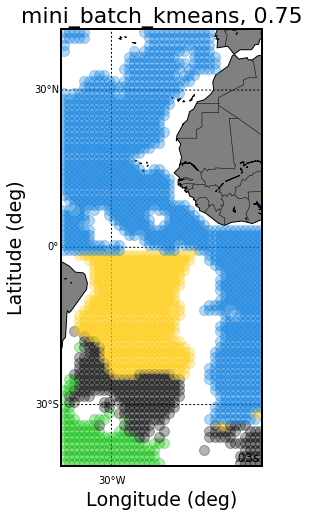

In [12]:
_x, _y, _feat_data, _basemap, _xLab, _yLab, _latLon_params = get_plan([-40,40], [-40,0], ['salinity', 'temperature'], 4000)
#_x, _y, _feat_data, _basemap, _xLab, _yLab, _latLon_params = get_section('EW_section', -40, [-40,0], ['nitrate'])
# _x, _y, _feat_data, _basemap, _xLab, _yLab, _latLon_params = get_section('NS_section', -30, [-40,0], ['salinity', 'temperature'])

models_st = test_clustering4(_x, _y, _feat_data, _xLab, _yLab, 4, _latLon_params, _basemap, ['mini_batch_kmeans'])
pred_dict, fig = plot_model_output(_x, _y, _xLab, _yLab, -40, 40, -40, 0, _latLon_params, models_st['mini_batch_kmeans'], 'mini_batch_kmeans', 'plan', sil = "no")

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: SADeprecationWarning: reflect=True is deprecate; please use the reflect() method.
  # Remove the CWD from sys.path while we load stuff.


[('mini_batch_kmeans', MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=3,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0))]
0.0465703010559082


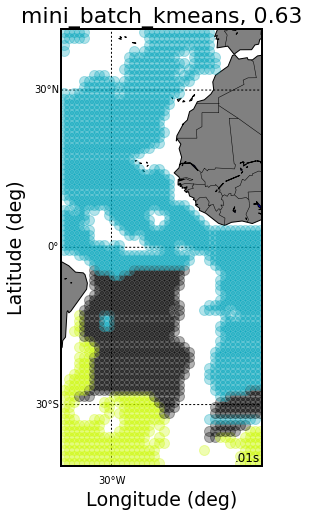

In [13]:
_x, _y, _feat_data, _basemap, _xLab, _yLab, _latLon_params = get_plan([-40,40], [-40,0], ['phostphate','nitrate'], 4000)
#_x, _y, _feat_data, _basemap, _xLab, _yLab, _latLon_params = get_section('EW_section', -40, [-40,0], ['nitrate'])
# _x, _y, _feat_data, _basemap, _xLab, _yLab, _latLon_params = get_section('NS_section', -30, [-40,0], ['phostphate','nitrate'])

models_np = test_clustering4(_x, _y, _feat_data, _xLab, _yLab, 3, _latLon_params, _basemap, ['mini_batch_kmeans'])
pred_dict, fig = plot_model_output(_x, _y, _xLab, _yLab, -40, 40, -40, 0, _latLon_params, models_np['mini_batch_kmeans'], 'mini_batch_kmeans', 'plan', sil = "no")

In [14]:
y_pred1 = list(models_np['mini_batch_kmeans']['y_pred'])
y_pred2 = list(models_st['mini_batch_kmeans']['y_pred'])

In [15]:
color1 = y_pred1[0]
color2 = y_pred2[0]
ctr = 0
mapping = {}
for ik in range(len(y_pred1)):
    if y_pred1[ik]== color1 and y_pred2[ik]== color2:
        ctr += 1
        if ctr == 50 and color1 not in mapping and color2 not in mapping.values():
            mapping[color1]=color2
            ctr = 0
            print(mapping)
    else:
        color1 = y_pred1[ik]
        color2 = y_pred2[ik]
        ctr = 0

        
        
remaining = []
c1 = Counter(y_pred1)
for ik in range(len(c1)):
    if ik not in mapping:
        remaining.append(ik)
        
ctr = 0
print(remaining)
for remainder in remaining:
    color1 = remainder
    for ik in range(100,len(y_pred1)):
        c = Counter(y_pred1[ik-100:ik])
        if color1 in c and c[color1]/100 >.6 and y_pred2[ik] not in mapping.values():
            mapping[color1]=y_pred2[ik]
        
    
N_CLUSTERS = len(c1)
for ik in range(N_CLUSTERS):
    if ik not in mapping:
        for ij in range(N_CLUSTERS):
            if ij not in mapping.values():
                mapping[ik]=ij
                
mapping

{1: 1}
[0, 2]


{0: 3, 1: 1, 2: 0}

In [16]:
for ik in range(len(y_pred1)):
    try:
        y_pred1[ik] = mapping[y_pred1[ik]]
    except:
        y_pred1[ik] = None

In [17]:
print(y_pred2[0:10])
print(y_pred1[0:10])
# models[model2]['y_pred'][1:10]

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [18]:
error_labels = []#list(len(models[model2]['y_pred']))#np.zeros((len(models[model2]['y_pred']), 1))

for ik in range(len(y_pred2)):
#     if models[model1]['y_pred'][ik] != models[model2]['y_pred'][ik]:
    if y_pred1[ik] != y_pred2[ik]:
        error_labels.append('g')
    else:
        error_labels.append('b')

# error_labels = [int(error_labels[ik][0]) for ik in range(len(error_labels))]

0.04642605781555176


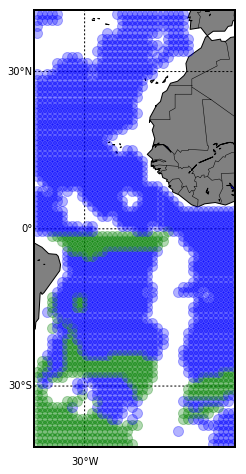

In [19]:
fig = plt.figure(figsize=(7*1, 7*1), facecolor='w')
ax = plt.subplot(100+10*1+1)
_basemap, fig, ax = bm.build_map('y', 'merc', -40, 40, -40, 0, 'c', fig, ax, 100+10*1+1, 'lb')

x,y = _basemap(_x, _y)
for im in range(len(x)):
    _basemap.plot(x[im], y[im], color = error_labels[im], marker = 'o', markersize=10, alpha = .3)  

plt.tight_layout(pad=3, w_pad=4., h_pad=3.0)